

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': True,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(50000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.0, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.1, 'epochs':120},
        'custom':{'dropout':0.1, 'epochs':120},
        'vgg':{'dropout':0.3, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

2021-08-10 14:41:44,351: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json


### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

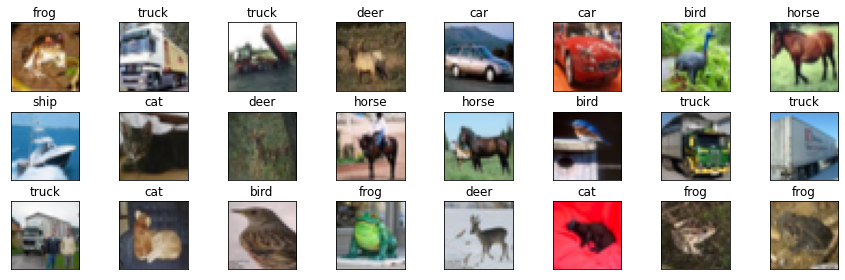

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

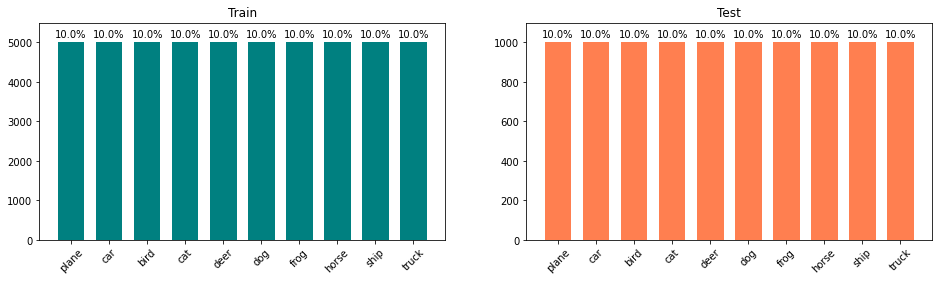

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

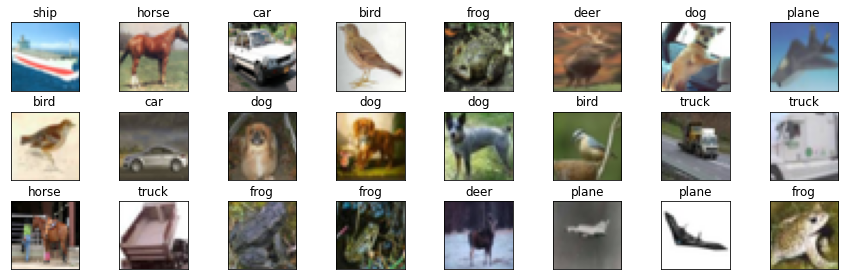

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

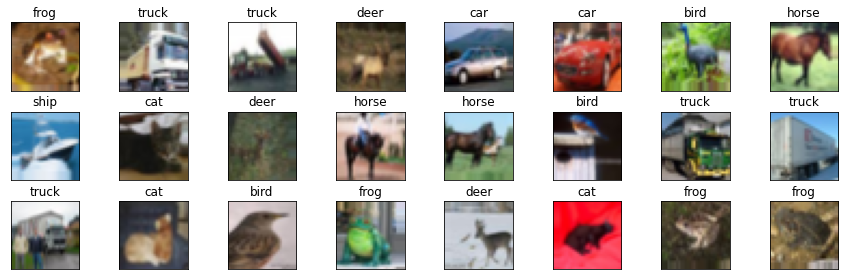

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

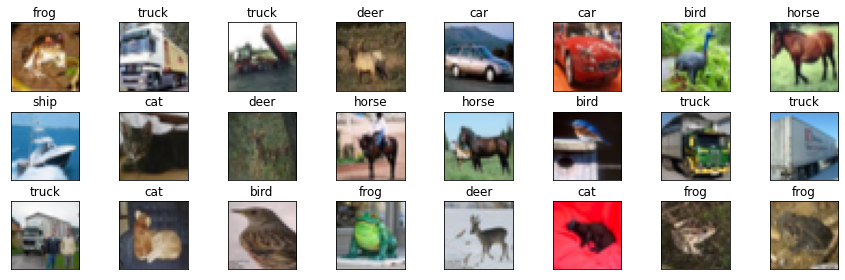

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = True


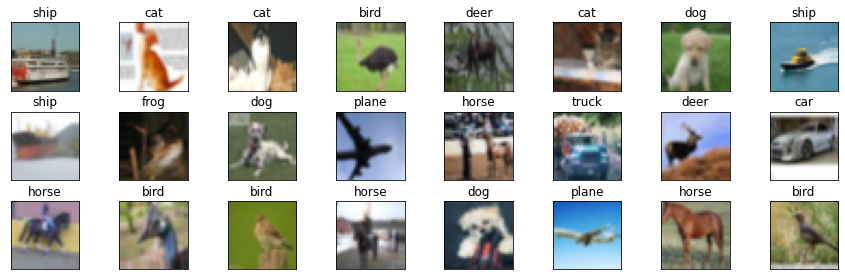

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-08-10 14:41:58,399: INFO: model_params.mlp1.dropout=0.0
2021-08-10 14:41:58,400: INFO: model_params.mlp1.layer_count=1
2021-08-10 14:41:58,401: INFO: model_params.mlp1.units=128
2021-08-10 14:41:58,460: INFO: learning_rate=0.001
2021-08-10 14:41:58,461: INFO: model_params.mlp1.clip_value=None
2021-08-10 14:41:58,480: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 14:41:58,483: INFO: model_params.mlp1.epochs=120
2021-08-10 14:41:58,483: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1, monitor=val_accuracy)
2021-08-10 14:41:58,484: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 14:41:58,485: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 14:41:58,485: INFO: use LearningRateScheduler()
2021-08-10 1

Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               393344    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.9494 - accuracy: 0.2942 - val_loss: 1.7908 - val_accuracy: 0.3550
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classif

2021-08-10 14:42:30,638: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 2/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.8266 - accuracy: 0.3423 - val_loss: 1.7880 - val_accuracy: 0.3562
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:43:02,442: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 3/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.8007 - accuracy: 0.3486 - val_loss: 1.7183 - val_accuracy: 0.3784
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:43:33,930: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 4/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7798 - accuracy: 0.3595 - val_loss: 1.7061 - val_accuracy: 0.3813
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:44:05,408: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 5/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7709 - accuracy: 0.3620 - val_loss: 1.7057 - val_accuracy: 0.3793
Epoch 6/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7560 - accuracy: 0.3671 - val_loss: 1.6924 - val_accuracy: 0.3863
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:45:07,578: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 7/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7550 - accuracy: 0.3676 - val_loss: 1.6890 - val_accuracy: 0.3908
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:45:39,161: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 8/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.7509 - accuracy: 0.3674 - val_loss: 1.6864 - val_accuracy: 0.3916
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:46:10,138: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 9/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7456 - accuracy: 0.3712 - val_loss: 1.6888 - val_accuracy: 0.3898
Epoch 10/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7439 - accuracy: 0.3708 - val_loss: 1.6653 - val_accuracy: 0.4030
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:47:12,354: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 11/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7364 - accuracy: 0.3726 - val_loss: 1.6760 - val_accuracy: 0.3996
Epoch 12/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7307 - accuracy: 0.3770 - val_loss: 1.6662 - val_accuracy: 0.4056
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:48:14,484: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 13/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7242 - accuracy: 0.3782 - val_loss: 1.6473 - val_accuracy: 0.4051
Epoch 14/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7241 - accuracy: 0.3790 - val_loss: 1.6658 - val_accuracy: 0.3961
Epoch 15/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7162 - accuracy: 0.3842 - val_loss: 1.6623 - val_accuracy: 0.3987
Epoch 16/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7160 - accuracy: 0.3819 - val_loss: 1.6481 - val_accuracy: 0.4130
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:50:18,960: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 17/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7132 - accuracy: 0.3833 - val_loss: 1.6468 - val_accuracy: 0.4077
Epoch 18/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7110 - accuracy: 0.3856 - val_loss: 1.7051 - val_accuracy: 0.3833
Epoch 19/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7143 - accuracy: 0.3837 - val_loss: 1.6310 - val_accuracy: 0.4119
Epoch 20/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7080 - accuracy: 0.3847 - val_loss: 1.6561 - val_accuracy: 0.4080
Epoch 21/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7038 - accuracy: 0.3860 - val_loss: 1.6396 - val_accuracy: 0.4132
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:53:02,652: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 22/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7049 - accuracy: 0.3874 - val_loss: 1.6427 - val_accuracy: 0.4093
Epoch 23/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.7011 - accuracy: 0.3891 - val_loss: 1.6801 - val_accuracy: 0.4033
Epoch 24/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6965 - accuracy: 0.3891 - val_loss: 1.6509 - val_accuracy: 0.4023
Epoch 25/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6984 - accuracy: 0.3896 - val_loss: 1.6206 - val_accuracy: 0.4141
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:55:07,225: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 26/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6944 - accuracy: 0.3893 - val_loss: 1.6356 - val_accuracy: 0.4038
Epoch 27/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6934 - accuracy: 0.3900 - val_loss: 1.6349 - val_accuracy: 0.4082
Epoch 28/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6951 - accuracy: 0.3901 - val_loss: 1.6429 - val_accuracy: 0.4096
Epoch 29/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6910 - accuracy: 0.3909 - val_loss: 1.6247 - val_accuracy: 0.4128
Epoch 30/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6915 - accuracy: 0.3911 - val_loss: 1.6212 - val_accuracy: 0.4189
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:57:42,570: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 31/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6862 - accuracy: 0.3922 - val_loss: 1.6174 - val_accuracy: 0.4121
Epoch 32/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6879 - accuracy: 0.3903 - val_loss: 1.6109 - val_accuracy: 0.4214
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 14:58:44,940: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 33/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6839 - accuracy: 0.3945 - val_loss: 1.6201 - val_accuracy: 0.4147
Epoch 34/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6871 - accuracy: 0.3930 - val_loss: 1.6175 - val_accuracy: 0.4108
Epoch 35/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6835 - accuracy: 0.3928 - val_loss: 1.6106 - val_accuracy: 0.4205
Epoch 36/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6819 - accuracy: 0.3910 - val_loss: 1.6252 - val_accuracy: 0.4144
Epoch 37/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6827 - accuracy: 0.3909 - val_loss: 1.6111 - val_accuracy: 0.4220
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 15:01:20,127: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 38/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6822 - accuracy: 0.3946 - val_loss: 1.6199 - val_accuracy: 0.4200
Epoch 39/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6813 - accuracy: 0.3946 - val_loss: 1.6069 - val_accuracy: 0.4203
Epoch 40/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6778 - accuracy: 0.3928 - val_loss: 1.6133 - val_accuracy: 0.4234
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 15:02:52,708: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 41/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6776 - accuracy: 0.3948 - val_loss: 1.6112 - val_accuracy: 0.4224
Epoch 42/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6771 - accuracy: 0.3979 - val_loss: 1.6354 - val_accuracy: 0.4154
Epoch 43/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6773 - accuracy: 0.3950 - val_loss: 1.6364 - val_accuracy: 0.4055
Epoch 44/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6785 - accuracy: 0.3974 - val_loss: 1.6022 - val_accuracy: 0.4226
Epoch 45/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6737 - accuracy: 0.3982 - val_loss: 1.6208 - val_accuracy: 0.4112
Epoch 46/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6754 - accuracy: 0.3964 - val_loss: 1.5926 - val_accuracy: 0.4270
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 15:05:58,727: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 47/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6721 - accuracy: 0.3954 - val_loss: 1.5871 - val_accuracy: 0.4325
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 15:06:30,075: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 48/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6730 - accuracy: 0.3968 - val_loss: 1.6246 - val_accuracy: 0.4168
Epoch 49/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6757 - accuracy: 0.3948 - val_loss: 1.6256 - val_accuracy: 0.4154
Epoch 50/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6751 - accuracy: 0.3967 - val_loss: 1.6149 - val_accuracy: 0.4163
Epoch 51/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6738 - accuracy: 0.3954 - val_loss: 1.6004 - val_accuracy: 0.4196
Epoch 52/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6688 - accuracy: 0.3987 - val_loss: 1.6461 - val_accuracy: 0.3986
Epoch 53/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6693 - accuracy: 0.3972 - val_loss: 1.6326 - val_accuracy: 0.4122
Epoch 54/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6681 - accuracy: 0.3970 - val_

2021-08-10 15:13:41,963: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 62/120
1562/1562 [==============================] - 30s 19ms/step - loss: 1.6343 - accuracy: 0.4147 - val_loss: 1.5719 - val_accuracy: 0.4354
Epoch 63/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6316 - accuracy: 0.4140 - val_loss: 1.5731 - val_accuracy: 0.4384
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 15:14:43,359: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 64/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6342 - accuracy: 0.4140 - val_loss: 1.5727 - val_accuracy: 0.4383
Epoch 65/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6316 - accuracy: 0.4142 - val_loss: 1.5735 - val_accuracy: 0.4364
Epoch 66/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6329 - accuracy: 0.4129 - val_loss: 1.5741 - val_accuracy: 0.4375
Epoch 67/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6319 - accuracy: 0.4137 - val_loss: 1.5729 - val_accuracy: 0.4368
Epoch 68/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6325 - accuracy: 0.4130 - val_loss: 1.5742 - val_accuracy: 0.4374
Epoch 69/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6332 - accuracy: 0.4141 - val_loss: 1.5722 - val_accuracy: 0.4370
Epoch 70/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6310 - accuracy: 0.4133 - val_

2021-08-10 15:20:24,563: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 75/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6326 - accuracy: 0.4132 - val_loss: 1.5740 - val_accuracy: 0.4384
Epoch 76/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6267 - accuracy: 0.4165 - val_loss: 1.5744 - val_accuracy: 0.4346
Epoch 77/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6280 - accuracy: 0.4155 - val_loss: 1.5723 - val_accuracy: 0.4374
Epoch 78/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6291 - accuracy: 0.4135 - val_loss: 1.5708 - val_accuracy: 0.4360
Epoch 79/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6314 - accuracy: 0.4133 - val_loss: 1.5752 - val_accuracy: 0.4371
Epoch 80/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6317 - accuracy: 0.4148 - val_loss: 1.5705 - val_accuracy: 0.4363
Epoch 81/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6318 - accuracy: 0.4146 - val_

2021-08-10 15:27:08,599: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 88/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6290 - accuracy: 0.4149 - val_loss: 1.5734 - val_accuracy: 0.4382
Epoch 89/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6294 - accuracy: 0.4142 - val_loss: 1.5730 - val_accuracy: 0.4391
Epoch 90/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6290 - accuracy: 0.4151 - val_loss: 1.5693 - val_accuracy: 0.4385
Epoch 91/120
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6254 - accuracy: 0.4158 - val_loss: 1.5682 - val_accuracy: 0.4387
Epoch 92/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6248 - accuracy: 0.4172 - val_loss: 1.5680 - val_accuracy: 0.4399
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


2021-08-10 15:29:44,617: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 93/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6244 - accuracy: 0.4172 - val_loss: 1.5672 - val_accuracy: 0.4392
Epoch 94/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6216 - accuracy: 0.4169 - val_loss: 1.5681 - val_accuracy: 0.4384
Epoch 95/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6237 - accuracy: 0.4174 - val_loss: 1.5667 - val_accuracy: 0.4383
Epoch 96/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6301 - accuracy: 0.4163 - val_loss: 1.5669 - val_accuracy: 0.4385
Epoch 97/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6230 - accuracy: 0.4162 - val_loss: 1.5678 - val_accuracy: 0.4393
Epoch 98/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6243 - accuracy: 0.4162 - val_loss: 1.5666 - val_accuracy: 0.4398
Epoch 99/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6246 - accuracy: 0.4164 - val_

2021-08-10 15:37:33,818: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1/assets


Epoch 108/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6249 - accuracy: 0.4155 - val_loss: 1.5668 - val_accuracy: 0.4396
Epoch 109/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6234 - accuracy: 0.4177 - val_loss: 1.5669 - val_accuracy: 0.4398
Epoch 110/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6246 - accuracy: 0.4153 - val_loss: 1.5668 - val_accuracy: 0.4398

Epoch 00110: ReduceLROnPlateau reducing learning rate to 5e-07.
Epoch 111/120
Epoch 00111: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6251 - accuracy: 0.4183 - val_loss: 1.5668 - val_accuracy: 0.4396
Epoch 112/120
Epoch 00112: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 1.6236 - accuracy: 0.4168 - val_loss: 1.5669 - val_accuracy: 0.4397
Epoch 113/120
Epoch 00113: Still keep learning rate 5e-07 instead of

2021-08-10 15:44:19,152: INFO: finish training [elapsed time: 3740.67 seconds]


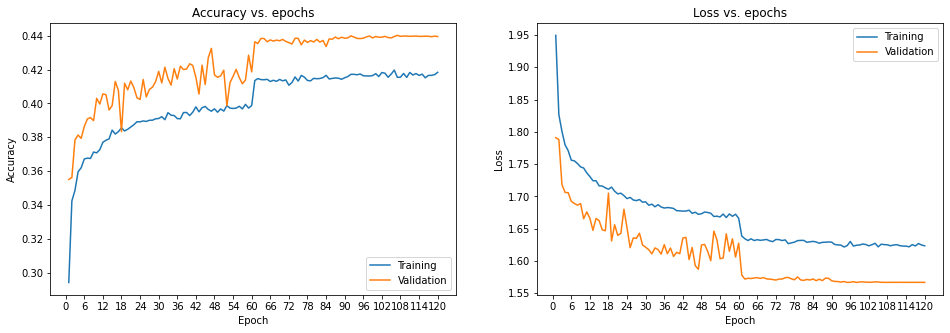

2021-08-10 15:44:19,777: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
----------------------------------------evaluate----------------------------------------


2021-08-10 15:44:28,453: INFO: test loss:1.5668
2021-08-10 15:44:28,454: INFO: test accuracy:0.4402
2021-08-10 15:44:28,455: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 15:44:28,456: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 15:44:28,457: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 15:44:28,458: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 15:44:28,459: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resne

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 15:44:33,784: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


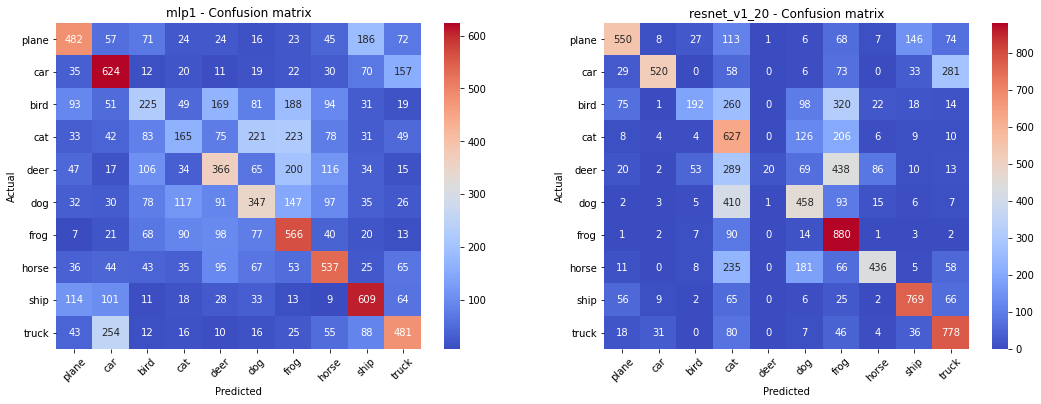

2021-08-10 15:44:40,313: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2021-08-10 15:44:45,431: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 15:44:45,433: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 15:44:46,561: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 15:44:46,564: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 15:44:47,568: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 15:44:47,571: INFO: loading model from /tf/eipi10/xuxiangwen.github.io

2021-08-10 15:44:51,101: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f974462d400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


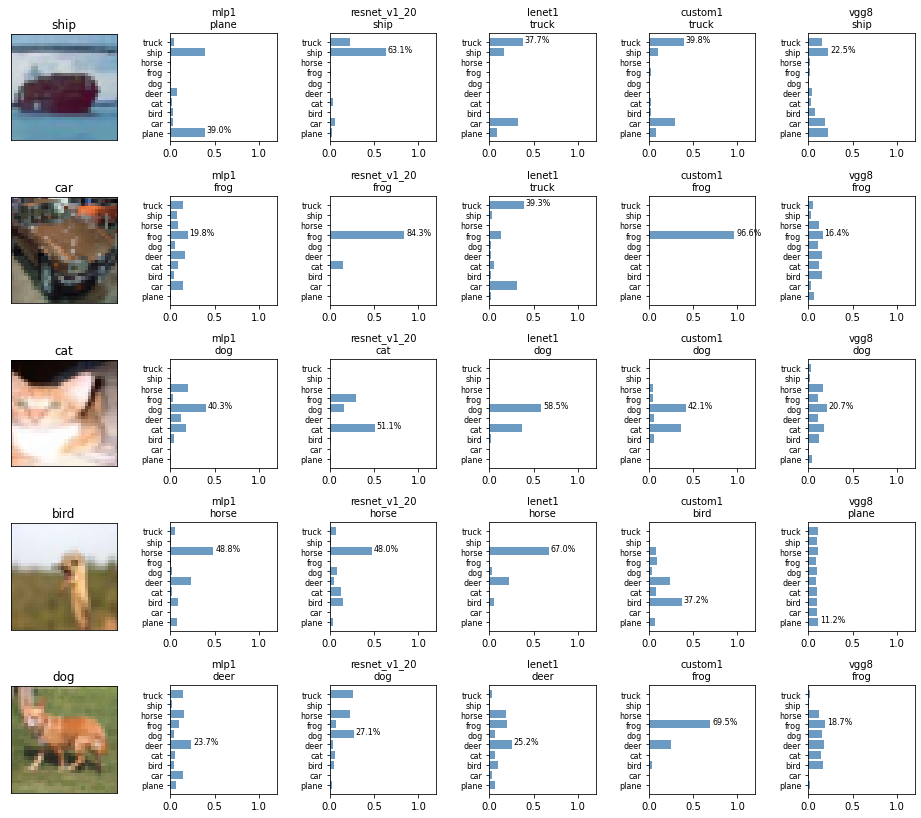

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc,create_time
1,resnet_v1_20,273066,56.3,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110,NaN
2,lenet1,83170,35.1,1.4518,1.4490,0.4711,0.4757,0.8793,0.8793,NaN
3,custom1,73738,34.9,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804,NaN
4,mlp1,394634,3740.2,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518,2021-08-10 15:44
5,vgg8,1672906,38.3,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986,NaN


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-08-10 15:44:56,061: INFO: model_params.lenet1.dropout=0.1
2021-08-10 15:44:56,146: INFO: learning_rate=0.001
2021-08-10 15:44:56,147: INFO: model_params.lenet1.clip_value=None
2021-08-10 15:44:56,153: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 15:44:56,158: INFO: model_params.lenet1.epochs=120
2021-08-10 15:44:56,159: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1, monitor=val_accuracy)
2021-08-10 15:44:56,159: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 15:44:56,160: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 15:44:56,161: INFO: use LearningRateScheduler()
2021-08-10 15:44:56,161: INFO: steps_per_epoch=1562
2021-08-10 15:44:56,162: INFO: start training
2021-08-10 15:44:56,162: I

Model: "lenet1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 6)         456       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 6)         24        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 6)         0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        2416      
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 16)        64   

2021-08-10 15:45:30,997: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 2/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.4750 - accuracy: 0.4705 - val_loss: 1.5123 - val_accuracy: 0.4651
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:46:04,562: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 3/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.3718 - accuracy: 0.5064 - val_loss: 1.2162 - val_accuracy: 0.5652
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:46:38,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 4/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.3027 - accuracy: 0.5345 - val_loss: 1.4108 - val_accuracy: 0.5202
Epoch 5/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.2525 - accuracy: 0.5547 - val_loss: 1.1267 - val_accuracy: 0.6019
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:47:43,349: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 6/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.2186 - accuracy: 0.5675 - val_loss: 1.0783 - val_accuracy: 0.6194
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:48:17,771: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 7/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.1787 - accuracy: 0.5843 - val_loss: 1.2457 - val_accuracy: 0.5642
Epoch 8/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.1477 - accuracy: 0.5959 - val_loss: 1.0014 - val_accuracy: 0.6513
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:49:22,746: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 9/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.1127 - accuracy: 0.6070 - val_loss: 1.0608 - val_accuracy: 0.6303
Epoch 10/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0940 - accuracy: 0.6149 - val_loss: 1.0218 - val_accuracy: 0.6370
Epoch 11/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.0763 - accuracy: 0.6235 - val_loss: 1.0089 - val_accuracy: 0.6462
Epoch 12/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0612 - accuracy: 0.6281 - val_loss: 0.9090 - val_accuracy: 0.6815
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:51:31,651: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 13/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0469 - accuracy: 0.6317 - val_loss: 0.9779 - val_accuracy: 0.6557
Epoch 14/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0365 - accuracy: 0.6356 - val_loss: 0.9426 - val_accuracy: 0.6713
Epoch 15/120
1562/1562 [==============================] - 32s 20ms/step - loss: 1.0251 - accuracy: 0.6409 - val_loss: 0.9723 - val_accuracy: 0.6581
Epoch 16/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.0165 - accuracy: 0.6416 - val_loss: 0.8721 - val_accuracy: 0.6962
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:53:40,540: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 17/120
1562/1562 [==============================] - 31s 20ms/step - loss: 1.0077 - accuracy: 0.6455 - val_loss: 0.8869 - val_accuracy: 0.6915
Epoch 18/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9980 - accuracy: 0.6499 - val_loss: 1.0440 - val_accuracy: 0.6390
Epoch 19/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9930 - accuracy: 0.6553 - val_loss: 0.9235 - val_accuracy: 0.6792
Epoch 20/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9862 - accuracy: 0.6527 - val_loss: 0.8779 - val_accuracy: 0.6946
Epoch 21/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9804 - accuracy: 0.6573 - val_loss: 0.8827 - val_accuracy: 0.6929
Epoch 22/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9758 - accuracy: 0.6581 - val_loss: 0.8530 - val_accuracy: 0.7049
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 15:56:51,841: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 23/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9734 - accuracy: 0.6577 - val_loss: 0.8931 - val_accuracy: 0.6938
Epoch 24/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9674 - accuracy: 0.6626 - val_loss: 0.8660 - val_accuracy: 0.6935
Epoch 25/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9501 - accuracy: 0.6682 - val_loss: 0.8436 - val_accuracy: 0.7064
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 15:58:29,057: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 26/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9555 - accuracy: 0.6659 - val_loss: 0.9583 - val_accuracy: 0.6676
Epoch 27/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9511 - accuracy: 0.6690 - val_loss: 1.1112 - val_accuracy: 0.6304
Epoch 28/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9494 - accuracy: 0.6699 - val_loss: 0.8056 - val_accuracy: 0.7210
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 16:00:06,501: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 29/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9401 - accuracy: 0.6724 - val_loss: 0.8655 - val_accuracy: 0.7032
Epoch 30/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9361 - accuracy: 0.6721 - val_loss: 0.8845 - val_accuracy: 0.6958
Epoch 31/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9308 - accuracy: 0.6744 - val_loss: 0.8697 - val_accuracy: 0.6977
Epoch 32/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9234 - accuracy: 0.6772 - val_loss: 0.8431 - val_accuracy: 0.7046
Epoch 33/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9263 - accuracy: 0.6761 - val_loss: 1.0701 - val_accuracy: 0.6312
Epoch 34/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.9281 - accuracy: 0.6755 - val_loss: 0.8414 - val_accuracy: 0.7144
Epoch 35/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.9189 - accuracy: 0.6788 - val_

2021-08-10 16:10:08,890: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 48/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8933 - accuracy: 0.6878 - val_loss: 0.8501 - val_accuracy: 0.7037
Epoch 49/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8842 - accuracy: 0.6896 - val_loss: 0.7617 - val_accuracy: 0.7382
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 16:11:14,779: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 50/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8890 - accuracy: 0.6898 - val_loss: 0.8818 - val_accuracy: 0.6947
Epoch 51/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8894 - accuracy: 0.6866 - val_loss: 0.9549 - val_accuracy: 0.6688
Epoch 52/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8889 - accuracy: 0.6909 - val_loss: 0.8168 - val_accuracy: 0.7190
Epoch 53/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8834 - accuracy: 0.6911 - val_loss: 0.8461 - val_accuracy: 0.7062
Epoch 54/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8815 - accuracy: 0.6908 - val_loss: 0.8566 - val_accuracy: 0.7058
Epoch 55/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8832 - accuracy: 0.6929 - val_loss: 0.7878 - val_accuracy: 0.7293
Epoch 56/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8744 - accuracy: 0.6947 - val_

2021-08-10 16:15:31,151: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 58/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8690 - accuracy: 0.6965 - val_loss: 0.8912 - val_accuracy: 0.6877
Epoch 59/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8782 - accuracy: 0.6911 - val_loss: 0.8205 - val_accuracy: 0.7164
Epoch 60/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.8739 - accuracy: 0.6919 - val_loss: 0.8940 - val_accuracy: 0.6929
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1562/1562 [==============================] - 31s 20ms/step - loss: 0.8400 - accuracy: 0.7062 - val_loss: 0.7697 - val_accuracy: 0.7333
Epoch 62/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8320 - accuracy: 0.7056 - val_loss: 0.7744 - val_accuracy: 0.7291
Epoch 63/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8302 - accuracy: 0.7101 - val_loss: 0.7518 - val_accuracy: 0.7417
INFO:tensorflow:Assets written t

2021-08-10 16:18:43,029: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 64/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8302 - accuracy: 0.7086 - val_loss: 0.7569 - val_accuracy: 0.7382
Epoch 65/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8268 - accuracy: 0.7111 - val_loss: 0.7495 - val_accuracy: 0.7398
Epoch 66/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8204 - accuracy: 0.7122 - val_loss: 0.7543 - val_accuracy: 0.7395
Epoch 67/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8202 - accuracy: 0.7132 - val_loss: 0.7346 - val_accuracy: 0.7467
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 16:20:53,138: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 68/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8228 - accuracy: 0.7133 - val_loss: 0.7559 - val_accuracy: 0.7381
Epoch 69/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8230 - accuracy: 0.7100 - val_loss: 0.7543 - val_accuracy: 0.7401
Epoch 70/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8125 - accuracy: 0.7149 - val_loss: 0.7341 - val_accuracy: 0.7460
Epoch 71/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8198 - accuracy: 0.7103 - val_loss: 0.7364 - val_accuracy: 0.7482
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 16:23:01,832: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 72/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8186 - accuracy: 0.7130 - val_loss: 0.7541 - val_accuracy: 0.7406
Epoch 73/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8173 - accuracy: 0.7152 - val_loss: 0.7320 - val_accuracy: 0.7490
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


2021-08-10 16:24:07,348: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1/assets


Epoch 74/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8181 - accuracy: 0.7150 - val_loss: 0.7532 - val_accuracy: 0.7413
Epoch 75/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.8133 - accuracy: 0.7145 - val_loss: 0.7465 - val_accuracy: 0.7415
Epoch 76/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8196 - accuracy: 0.7140 - val_loss: 0.7388 - val_accuracy: 0.7459
Epoch 77/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8181 - accuracy: 0.7120 - val_loss: 0.7435 - val_accuracy: 0.7446
Epoch 78/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8099 - accuracy: 0.7149 - val_loss: 0.7428 - val_accuracy: 0.7431
Epoch 79/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8077 - accuracy: 0.7153 - val_loss: 0.7569 - val_accuracy: 0.7378
Epoch 80/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.8120 - accuracy: 0.7169 - val_

2021-08-10 16:45:25,030: INFO: finish training [elapsed time: 3628.87 seconds]


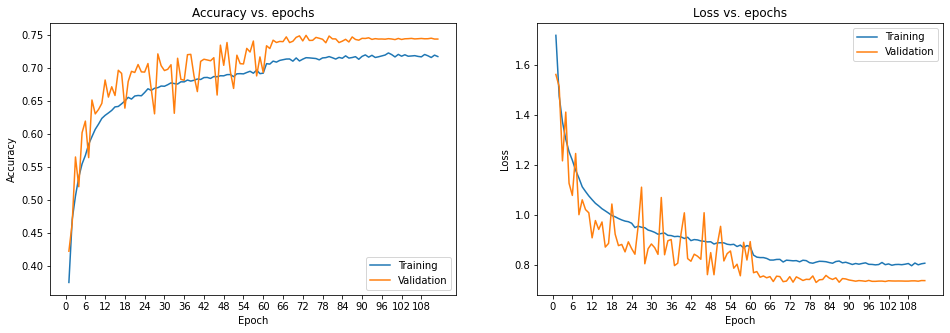

2021-08-10 16:45:25,607: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
----------------------------------------evaluate----------------------------------------


2021-08-10 16:45:39,615: INFO: test loss:0.7320
2021-08-10 16:45:39,616: INFO: test accuracy:0.7490
2021-08-10 16:45:39,619: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 16:45:39,621: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 16:45:39,622: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 16:45:39,623: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 16:45:39,625: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resne

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 16:45:45,228: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


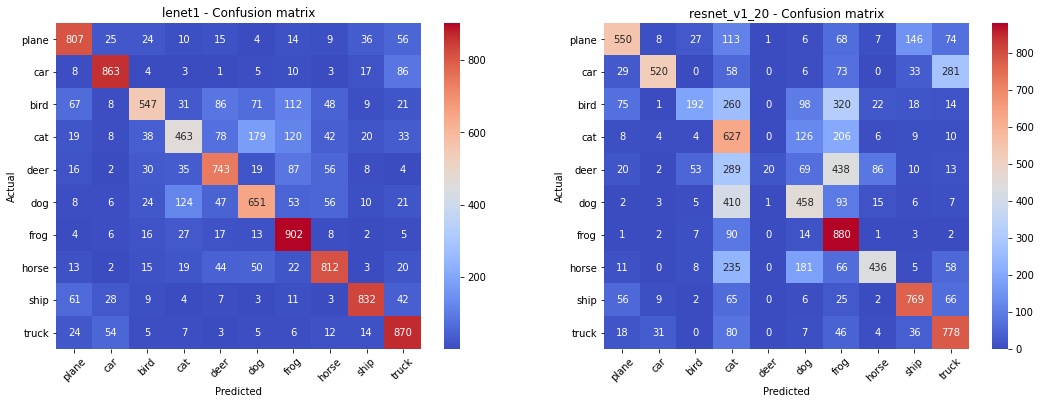

2021-08-10 16:45:51,216: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20


----------------------------------------sample analysis----------------------------------------


2021-08-10 16:45:56,990: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 16:45:56,992: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 16:45:58,024: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 16:45:58,026: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 16:45:58,290: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 16:45:58,291: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_

2021-08-10 16:46:02,286: WARNING: 5 out of the last 631 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f97f058b8c8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


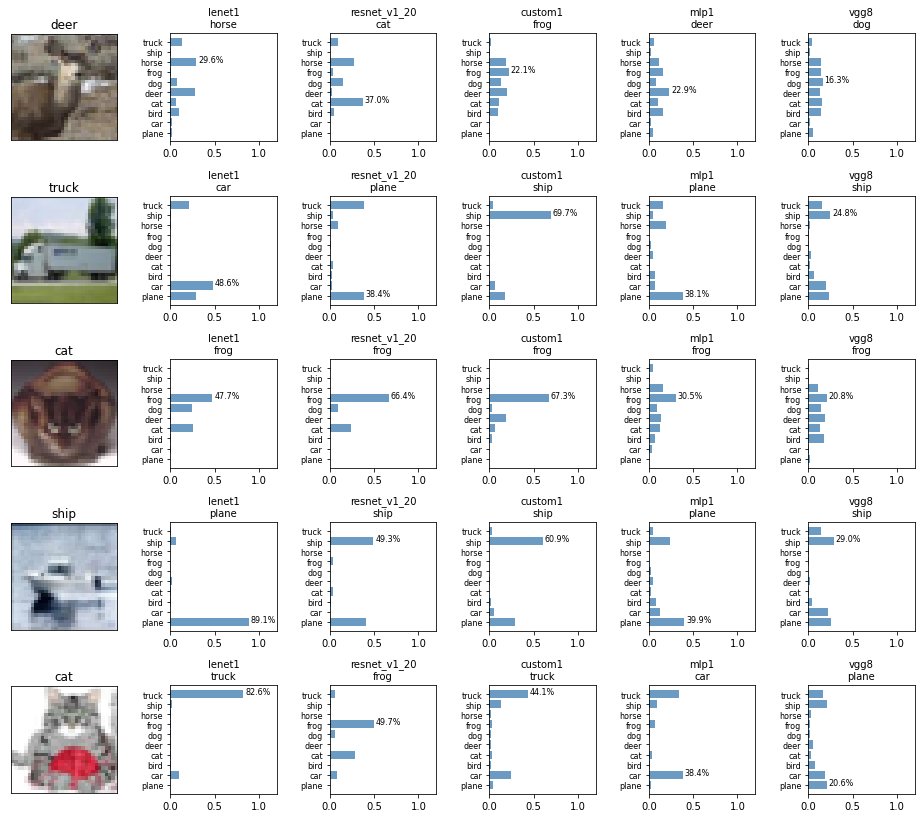

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,83170,3628.4,2021-08-10 16:45,0.6090,0.7320,0.7833,0.7490,0.9776,0.9674
2,resnet_v1_20,273066,56.3,NaN,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110
3,custom1,73738,34.9,NaN,1.5069,1.5039,0.4500,0.4500,0.8800,0.8804
4,mlp1,394634,3740.2,2021-08-10 15:44,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518
5,vgg8,1672906,38.3,NaN,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-08-10 16:46:06,785: INFO: model_params.custom1.dropout=0.1
2021-08-10 16:46:06,883: INFO: learning_rate=0.001
2021-08-10 16:46:06,884: INFO: model_params.custom1.clip_value=None
2021-08-10 16:46:06,890: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 16:46:06,896: INFO: model_params.custom1.epochs=120
2021-08-10 16:46:06,897: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1, monitor=val_accuracy)
2021-08-10 16:46:06,897: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 16:46:06,898: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 16:46:06,899: INFO: use LearningRateScheduler()
2021-08-10 16:46:06,899: INFO: steps_per_epoch=1562
2021-08-10 16:46:06,900: INFO: start training
2021-08-10 16:46:06,9

Model: "custom1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)        256 

2021-08-10 16:46:43,550: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 2/120
1562/1562 [==============================] - 32s 21ms/step - loss: 1.2885 - accuracy: 0.5406 - val_loss: 1.2509 - val_accuracy: 0.5593
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:47:18,396: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 3/120
1562/1562 [==============================] - 32s 21ms/step - loss: 1.1681 - accuracy: 0.5858 - val_loss: 1.4003 - val_accuracy: 0.5227
Epoch 4/120
1562/1562 [==============================] - 33s 21ms/step - loss: 1.0979 - accuracy: 0.6112 - val_loss: 1.1014 - val_accuracy: 0.6047
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:48:26,163: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 5/120
1562/1562 [==============================] - 32s 21ms/step - loss: 1.0425 - accuracy: 0.6315 - val_loss: 0.9501 - val_accuracy: 0.6603
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:49:01,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 6/120
1562/1562 [==============================] - 32s 21ms/step - loss: 1.0092 - accuracy: 0.6470 - val_loss: 1.0974 - val_accuracy: 0.6309
Epoch 7/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.9758 - accuracy: 0.6560 - val_loss: 1.2222 - val_accuracy: 0.5862
Epoch 8/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.9476 - accuracy: 0.6677 - val_loss: 0.9264 - val_accuracy: 0.6890
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:50:42,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 9/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.9220 - accuracy: 0.6779 - val_loss: 1.0533 - val_accuracy: 0.6346
Epoch 10/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.9093 - accuracy: 0.6817 - val_loss: 0.8038 - val_accuracy: 0.7198
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:51:49,500: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 11/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.8902 - accuracy: 0.6890 - val_loss: 1.1093 - val_accuracy: 0.6274
Epoch 12/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.8795 - accuracy: 0.6899 - val_loss: 0.8743 - val_accuracy: 0.7002
Epoch 13/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8604 - accuracy: 0.6990 - val_loss: 0.8098 - val_accuracy: 0.7152
Epoch 14/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8486 - accuracy: 0.7040 - val_loss: 0.8424 - val_accuracy: 0.7165
Epoch 15/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8398 - accuracy: 0.7072 - val_loss: 0.7430 - val_accuracy: 0.7426
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:54:34,702: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 16/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8304 - accuracy: 0.7128 - val_loss: 0.8058 - val_accuracy: 0.7197
Epoch 17/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8168 - accuracy: 0.7161 - val_loss: 0.8827 - val_accuracy: 0.6948
Epoch 18/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.8123 - accuracy: 0.7148 - val_loss: 0.8712 - val_accuracy: 0.7118
Epoch 19/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.8020 - accuracy: 0.7189 - val_loss: 0.7034 - val_accuracy: 0.7549
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:56:48,300: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 20/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7987 - accuracy: 0.7200 - val_loss: 0.6785 - val_accuracy: 0.7639
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:57:23,035: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 21/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.7872 - accuracy: 0.7249 - val_loss: 0.8239 - val_accuracy: 0.7195
Epoch 22/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7770 - accuracy: 0.7280 - val_loss: 0.6891 - val_accuracy: 0.7618
Epoch 23/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7783 - accuracy: 0.7305 - val_loss: 0.6597 - val_accuracy: 0.7697
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 16:59:02,813: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 24/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7699 - accuracy: 0.7318 - val_loss: 0.7771 - val_accuracy: 0.7408
Epoch 25/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.7659 - accuracy: 0.7336 - val_loss: 0.7308 - val_accuracy: 0.7476
Epoch 26/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.7538 - accuracy: 0.7375 - val_loss: 0.7153 - val_accuracy: 0.7541
Epoch 27/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.7522 - accuracy: 0.7412 - val_loss: 0.6768 - val_accuracy: 0.7614
Epoch 28/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7515 - accuracy: 0.7382 - val_loss: 0.6535 - val_accuracy: 0.7786
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 17:01:47,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 29/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.7548 - accuracy: 0.7373 - val_loss: 0.6630 - val_accuracy: 0.7737
Epoch 30/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7399 - accuracy: 0.7437 - val_loss: 0.6682 - val_accuracy: 0.7649
Epoch 31/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7396 - accuracy: 0.7419 - val_loss: 0.8243 - val_accuracy: 0.7214
Epoch 32/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7360 - accuracy: 0.7471 - val_loss: 0.6657 - val_accuracy: 0.7688
Epoch 33/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7340 - accuracy: 0.7457 - val_loss: 0.6352 - val_accuracy: 0.7767
Epoch 34/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7268 - accuracy: 0.7475 - val_loss: 0.6526 - val_accuracy: 0.7707
Epoch 35/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7242 - accuracy: 0.7473 - val_

2021-08-10 17:06:48,981: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 38/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7100 - accuracy: 0.7534 - val_loss: 0.6431 - val_accuracy: 0.7783
Epoch 39/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7133 - accuracy: 0.7526 - val_loss: 0.6432 - val_accuracy: 0.7795
Epoch 40/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7108 - accuracy: 0.7522 - val_loss: 0.7494 - val_accuracy: 0.7448
Epoch 41/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7031 - accuracy: 0.7554 - val_loss: 0.6690 - val_accuracy: 0.7696
Epoch 42/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.7006 - accuracy: 0.7571 - val_loss: 0.6732 - val_accuracy: 0.7704
Epoch 43/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6972 - accuracy: 0.7582 - val_loss: 0.6034 - val_accuracy: 0.7958
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classificati

2021-08-10 17:10:05,307: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 44/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.6921 - accuracy: 0.7600 - val_loss: 0.7823 - val_accuracy: 0.7353
Epoch 45/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6997 - accuracy: 0.7577 - val_loss: 0.6804 - val_accuracy: 0.7680
Epoch 46/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6941 - accuracy: 0.7601 - val_loss: 0.6220 - val_accuracy: 0.7885
Epoch 47/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6892 - accuracy: 0.7609 - val_loss: 0.6049 - val_accuracy: 0.7895
Epoch 48/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6923 - accuracy: 0.7580 - val_loss: 0.6341 - val_accuracy: 0.7804
Epoch 49/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6832 - accuracy: 0.7618 - val_loss: 0.7330 - val_accuracy: 0.7483
Epoch 50/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6853 - accuracy: 0.7630 - val_

2021-08-10 17:16:04,460: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 55/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6719 - accuracy: 0.7678 - val_loss: 0.6695 - val_accuracy: 0.7687
Epoch 56/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6722 - accuracy: 0.7678 - val_loss: 0.6782 - val_accuracy: 0.7697
Epoch 57/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6719 - accuracy: 0.7674 - val_loss: 0.6160 - val_accuracy: 0.7845
Epoch 58/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6693 - accuracy: 0.7687 - val_loss: 0.6431 - val_accuracy: 0.7764
Epoch 59/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6671 - accuracy: 0.7676 - val_loss: 0.8040 - val_accuracy: 0.7347
Epoch 60/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6657 - accuracy: 0.7688 - val_loss: 0.8402 - val_accuracy: 0.7228
Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1562/1562 [========

2021-08-10 17:19:53,384: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 62/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.6228 - accuracy: 0.7829 - val_loss: 0.5603 - val_accuracy: 0.8032
Epoch 63/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6150 - accuracy: 0.7855 - val_loss: 0.5441 - val_accuracy: 0.8103
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


2021-08-10 17:21:00,599: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 64/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6116 - accuracy: 0.7883 - val_loss: 0.5513 - val_accuracy: 0.8048
Epoch 65/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6150 - accuracy: 0.7871 - val_loss: 0.5569 - val_accuracy: 0.8074
Epoch 66/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.6098 - accuracy: 0.7874 - val_loss: 0.5489 - val_accuracy: 0.8076
Epoch 67/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.6112 - accuracy: 0.7856 - val_loss: 0.5610 - val_accuracy: 0.8029
Epoch 68/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6053 - accuracy: 0.7895 - val_loss: 0.5521 - val_accuracy: 0.8045
Epoch 69/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6026 - accuracy: 0.7910 - val_loss: 0.5621 - val_accuracy: 0.8039
Epoch 70/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.6050 - accuracy: 0.7909 - val_

2021-08-10 17:25:19,844: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 72/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6035 - accuracy: 0.7897 - val_loss: 0.5449 - val_accuracy: 0.8091
Epoch 73/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.6044 - accuracy: 0.7907 - val_loss: 0.5436 - val_accuracy: 0.8095
Epoch 74/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5960 - accuracy: 0.7921 - val_loss: 0.5557 - val_accuracy: 0.8055
Epoch 75/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5974 - accuracy: 0.7927 - val_loss: 0.5521 - val_accuracy: 0.8058
Epoch 76/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5955 - accuracy: 0.7928 - val_loss: 0.5461 - val_accuracy: 0.8091
Epoch 77/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5978 - accuracy: 0.7933 - val_loss: 0.5452 - val_accuracy: 0.8091
Epoch 78/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5959 - accuracy: 0.7930 - val_

2021-08-10 17:31:18,650: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 83/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5944 - accuracy: 0.7941 - val_loss: 0.5444 - val_accuracy: 0.8080
Epoch 84/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.6020 - accuracy: 0.7898 - val_loss: 0.5354 - val_accuracy: 0.8130
Epoch 85/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5911 - accuracy: 0.7967 - val_loss: 0.5357 - val_accuracy: 0.8128
Epoch 86/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5942 - accuracy: 0.7941 - val_loss: 0.5503 - val_accuracy: 0.8073

Epoch 00086: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
Epoch 87/120
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5938 - accuracy: 0.7944 - val_loss: 0.5342 - val_accuracy: 0.8144
Epoch 88/120
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [========================

2021-08-10 17:41:00,428: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1/assets


Epoch 101/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.5895 - accuracy: 0.7950 - val_loss: 0.5306 - val_accuracy: 0.8149
Epoch 102/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.5841 - accuracy: 0.7963 - val_loss: 0.5345 - val_accuracy: 0.8136
Epoch 103/120
1562/1562 [==============================] - 32s 20ms/step - loss: 0.5871 - accuracy: 0.7958 - val_loss: 0.5345 - val_accuracy: 0.8123
Epoch 104/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5868 - accuracy: 0.7961 - val_loss: 0.5326 - val_accuracy: 0.8135
Epoch 105/120
1562/1562 [==============================] - 32s 21ms/step - loss: 0.5829 - accuracy: 0.7956 - val_loss: 0.5344 - val_accuracy: 0.8112
Epoch 106/120
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 1e-05.
1562/1562 [==============================] - 33s 21ms/step - loss: 0.5880 - accuracy: 0.7956 - val_loss: 0.5348 - val_accuracy: 0.8123
Epoch 107/120
1562/1562 [==

2021-08-10 17:51:43,354: INFO: finish training [elapsed time: 3936.45 seconds]


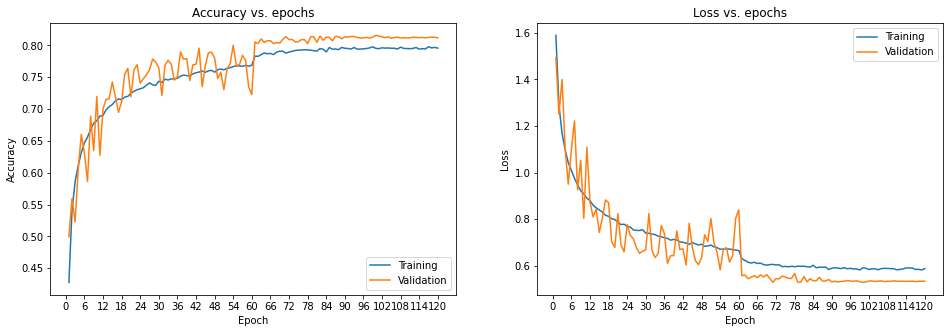

2021-08-10 17:51:43,885: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
----------------------------------------evaluate----------------------------------------


2021-08-10 17:51:57,490: INFO: test loss:0.5284
2021-08-10 17:51:57,491: INFO: test accuracy:0.8159
2021-08-10 17:51:57,493: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 17:51:57,495: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 17:51:57,496: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 17:51:57,498: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 17:51:57,499: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 17:51:58,321: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


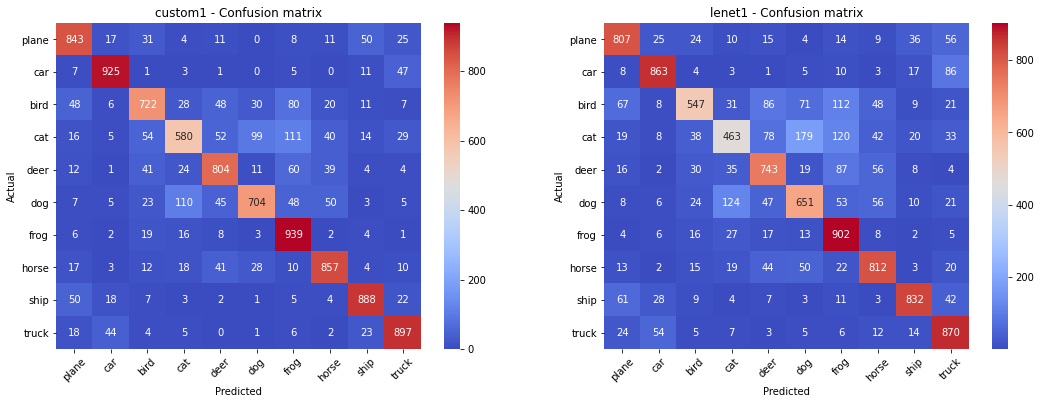

2021-08-10 17:52:02,438: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1


----------------------------------------sample analysis----------------------------------------


2021-08-10 17:52:03,687: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 17:52:03,689: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 17:52:08,518: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 17:52:08,521: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/mlp1
2021-08-10 17:52:08,854: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 17:52:08,856: INFO: loading model from /tf/eipi10/xuxiangwen.github

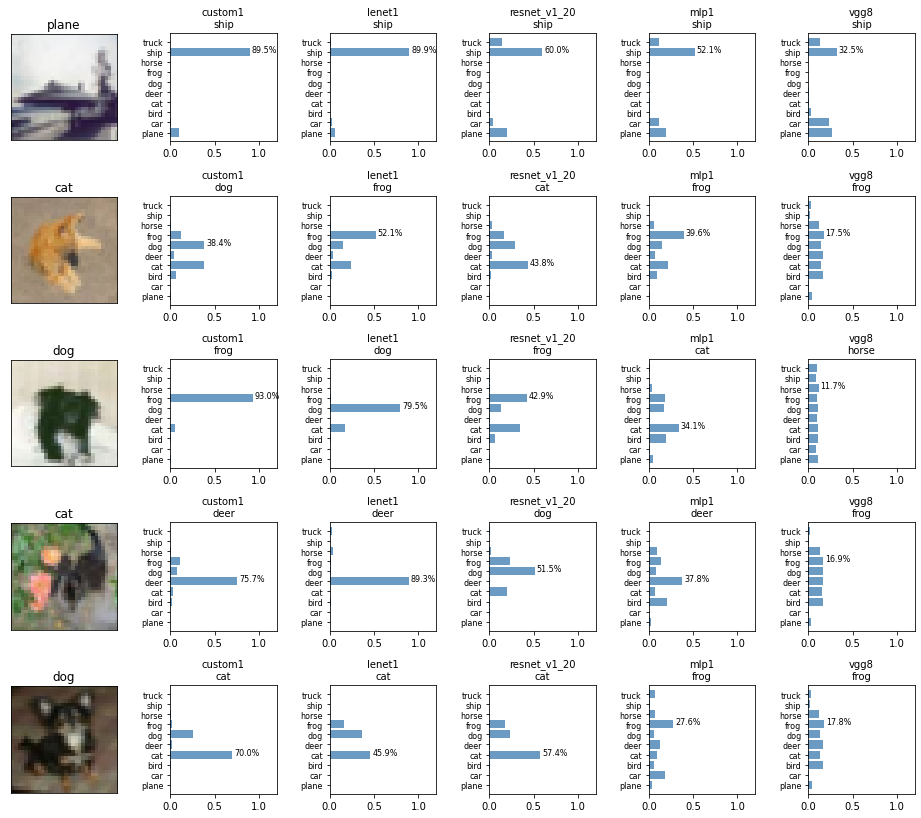

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,73738,3936.0,2021-08-10 17:51,0.4275,0.5284,0.8501,0.8159,0.9886,0.9827
2,lenet1,83170,3628.4,2021-08-10 16:45,0.6090,0.7320,0.7833,0.7490,0.9776,0.9674
3,resnet_v1_20,273066,56.3,NaN,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110
4,mlp1,394634,3740.2,2021-08-10 15:44,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518
5,vgg8,1672906,38.3,NaN,1.8348,1.8329,0.2901,0.2886,0.7975,0.7986


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-08-10 17:52:17,336: INFO: model_params.vgg8.dropout=0.3
2021-08-10 17:52:18,037: INFO: learning_rate=0.001
2021-08-10 17:52:18,038: INFO: model_params.vgg8.clip_value=None
2021-08-10 17:52:18,046: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
2021-08-10 17:52:18,064: INFO: model_params.vgg8.epochs=120
2021-08-10 17:52:18,065: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8, monitor=val_accuracy)
2021-08-10 17:52:18,065: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 17:52:18,066: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 17:52:18,066: INFO: use LearningRateScheduler()
2021-08-10 17:52:18,067: INFO: steps_per_epoch=1562
2021-08-10 17:52:18,068: INFO: start training
2021-08-10 17:52:18,068: INFO: use_c

Model: "vgg8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_con1 (Conv2D)         (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_bn1 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu1 (ReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
block1_con2 (Conv2D)         (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_bn2 (BatchNormalizati (None, 32, 32, 64)        256       
_________________________________________________________________
block1_relu2 (ReLU)          (None, 32, 32, 64)        0      

2021-08-10 17:52:59,286: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 2/120
1562/1562 [==============================] - 35s 23ms/step - loss: 1.5853 - accuracy: 0.3783 - val_loss: 1.3232 - val_accuracy: 0.4759
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:53:38,847: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 3/120
1562/1562 [==============================] - 36s 23ms/step - loss: 1.4533 - accuracy: 0.4394 - val_loss: 1.3244 - val_accuracy: 0.5174
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:54:18,611: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 4/120
1562/1562 [==============================] - 36s 23ms/step - loss: 1.3599 - accuracy: 0.4886 - val_loss: 1.0152 - val_accuracy: 0.6489
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:54:59,218: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 5/120
1562/1562 [==============================] - 36s 23ms/step - loss: 1.2598 - accuracy: 0.5367 - val_loss: 1.2665 - val_accuracy: 0.5875
Epoch 6/120
1562/1562 [==============================] - 36s 23ms/step - loss: 1.1061 - accuracy: 0.6041 - val_loss: 1.3854 - val_accuracy: 0.5883
Epoch 7/120
1562/1562 [==============================] - 36s 23ms/step - loss: 1.0192 - accuracy: 0.6416 - val_loss: 0.7749 - val_accuracy: 0.7450
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:56:51,142: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 8/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.9350 - accuracy: 0.6753 - val_loss: 0.7534 - val_accuracy: 0.7445
Epoch 9/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.8429 - accuracy: 0.7131 - val_loss: 0.6751 - val_accuracy: 0.7803
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:58:07,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 10/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.7883 - accuracy: 0.7341 - val_loss: 0.7744 - val_accuracy: 0.7581
Epoch 11/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.7438 - accuracy: 0.7508 - val_loss: 0.6278 - val_accuracy: 0.7939
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 17:59:22,815: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 12/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.6890 - accuracy: 0.7705 - val_loss: 0.6174 - val_accuracy: 0.8084
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:00:03,501: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 13/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.6262 - accuracy: 0.7932 - val_loss: 0.6639 - val_accuracy: 0.7849
Epoch 14/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.5813 - accuracy: 0.8085 - val_loss: 0.5524 - val_accuracy: 0.8266
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:01:18,916: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 15/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.5474 - accuracy: 0.8207 - val_loss: 0.5422 - val_accuracy: 0.8203
Epoch 16/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.5253 - accuracy: 0.8277 - val_loss: 0.4859 - val_accuracy: 0.8438
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:02:35,236: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 17/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4934 - accuracy: 0.8371 - val_loss: 0.4792 - val_accuracy: 0.8394
Epoch 18/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4728 - accuracy: 0.8439 - val_loss: 0.5377 - val_accuracy: 0.8302
Epoch 19/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4583 - accuracy: 0.8491 - val_loss: 0.4315 - val_accuracy: 0.8583
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:04:26,513: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 20/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4372 - accuracy: 0.8560 - val_loss: 0.4917 - val_accuracy: 0.8491
Epoch 21/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4263 - accuracy: 0.8585 - val_loss: 0.4344 - val_accuracy: 0.8608
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:05:42,246: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 22/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.4130 - accuracy: 0.8638 - val_loss: 0.4639 - val_accuracy: 0.8470
Epoch 23/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3944 - accuracy: 0.8686 - val_loss: 0.6069 - val_accuracy: 0.8247
Epoch 24/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3847 - accuracy: 0.8704 - val_loss: 0.4124 - val_accuracy: 0.8665
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:07:33,945: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 25/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3757 - accuracy: 0.8756 - val_loss: 0.5115 - val_accuracy: 0.8476
Epoch 26/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3678 - accuracy: 0.8758 - val_loss: 0.7437 - val_accuracy: 0.8022
Epoch 27/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.3573 - accuracy: 0.8800 - val_loss: 0.4440 - val_accuracy: 0.8670
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:09:23,471: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 28/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3545 - accuracy: 0.8815 - val_loss: 0.4956 - val_accuracy: 0.8574
Epoch 29/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3393 - accuracy: 0.8850 - val_loss: 0.4397 - val_accuracy: 0.8645
Epoch 30/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3356 - accuracy: 0.8865 - val_loss: 0.3931 - val_accuracy: 0.8758
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:11:14,913: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 31/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3257 - accuracy: 0.8909 - val_loss: 0.4679 - val_accuracy: 0.8605
Epoch 32/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3232 - accuracy: 0.8918 - val_loss: 0.3769 - val_accuracy: 0.8782
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:12:30,983: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 33/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3189 - accuracy: 0.8934 - val_loss: 0.4531 - val_accuracy: 0.8724
Epoch 34/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3106 - accuracy: 0.8955 - val_loss: 0.4351 - val_accuracy: 0.8700
Epoch 35/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3098 - accuracy: 0.8963 - val_loss: 0.4052 - val_accuracy: 0.8803
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:14:22,525: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 36/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.3039 - accuracy: 0.8959 - val_loss: 0.3899 - val_accuracy: 0.8809
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:15:01,003: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 37/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.3034 - accuracy: 0.8972 - val_loss: 0.4471 - val_accuracy: 0.8653
Epoch 38/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2885 - accuracy: 0.9014 - val_loss: 0.4561 - val_accuracy: 0.8693
Epoch 39/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2887 - accuracy: 0.9024 - val_loss: 0.4062 - val_accuracy: 0.8812
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:16:52,747: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 40/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2837 - accuracy: 0.9040 - val_loss: 0.4281 - val_accuracy: 0.8688
Epoch 41/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2746 - accuracy: 0.9065 - val_loss: 0.4305 - val_accuracy: 0.8746
Epoch 42/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2765 - accuracy: 0.9067 - val_loss: 0.3648 - val_accuracy: 0.8915
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:18:45,099: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 43/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2706 - accuracy: 0.9078 - val_loss: 0.3599 - val_accuracy: 0.8904
Epoch 44/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2673 - accuracy: 0.9087 - val_loss: 0.4477 - val_accuracy: 0.8774
Epoch 45/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2667 - accuracy: 0.9093 - val_loss: 0.4416 - val_accuracy: 0.8760
Epoch 46/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2631 - accuracy: 0.9111 - val_loss: 0.3514 - val_accuracy: 0.8881
Epoch 47/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2552 - accuracy: 0.9137 - val_loss: 0.4069 - val_accuracy: 0.8834
Epoch 48/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2549 - accuracy: 0.9143 - val_loss: 0.3903 - val_accuracy: 0.8908
Epoch 49/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2573 - accuracy: 0.9120 - val_

2021-08-10 18:23:00,371: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 50/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2477 - accuracy: 0.9150 - val_loss: 0.3599 - val_accuracy: 0.8910
Epoch 51/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2498 - accuracy: 0.9147 - val_loss: 0.3781 - val_accuracy: 0.8933
Epoch 52/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2386 - accuracy: 0.9178 - val_loss: 0.3513 - val_accuracy: 0.8989
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:24:52,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 53/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2390 - accuracy: 0.9176 - val_loss: 0.4764 - val_accuracy: 0.8751
Epoch 54/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.2355 - accuracy: 0.9199 - val_loss: 0.3960 - val_accuracy: 0.8893
Epoch 55/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2382 - accuracy: 0.9192 - val_loss: 0.3672 - val_accuracy: 0.8970
Epoch 56/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2364 - accuracy: 0.9201 - val_loss: 0.4089 - val_accuracy: 0.8839
Epoch 57/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2319 - accuracy: 0.9193 - val_loss: 0.3690 - val_accuracy: 0.8988
Epoch 58/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2223 - accuracy: 0.9235 - val_loss: 0.3675 - val_accuracy: 0.8944
Epoch 59/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2277 - accuracy: 0.9214 - val_

2021-08-10 18:29:06,014: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 60/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.2233 - accuracy: 0.9254 - val_loss: 0.3535 - val_accuracy: 0.9016
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:29:46,245: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 61/120
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.001.
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1949 - accuracy: 0.9344 - val_loss: 0.3326 - val_accuracy: 0.9063
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:30:26,468: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 62/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1796 - accuracy: 0.9386 - val_loss: 0.3321 - val_accuracy: 0.9086
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:31:06,936: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 63/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1732 - accuracy: 0.9402 - val_loss: 0.3254 - val_accuracy: 0.9115
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:31:45,228: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 64/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1650 - accuracy: 0.9435 - val_loss: 0.3285 - val_accuracy: 0.9111
Epoch 65/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1615 - accuracy: 0.9441 - val_loss: 0.3307 - val_accuracy: 0.9116
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:33:01,425: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 66/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1581 - accuracy: 0.9461 - val_loss: 0.3291 - val_accuracy: 0.9102
Epoch 67/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1548 - accuracy: 0.9471 - val_loss: 0.3230 - val_accuracy: 0.9145
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:34:15,604: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 68/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1540 - accuracy: 0.9474 - val_loss: 0.3225 - val_accuracy: 0.9138
Epoch 69/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.1525 - accuracy: 0.9468 - val_loss: 0.3248 - val_accuracy: 0.9156
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:35:30,540: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 70/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1542 - accuracy: 0.9474 - val_loss: 0.3257 - val_accuracy: 0.9132
Epoch 71/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1504 - accuracy: 0.9487 - val_loss: 0.3331 - val_accuracy: 0.9118
Epoch 72/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1507 - accuracy: 0.9484 - val_loss: 0.3364 - val_accuracy: 0.9127
Epoch 73/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.1459 - accuracy: 0.9483 - val_loss: 0.3287 - val_accuracy: 0.9153
Epoch 74/120
1562/1562 [==============================] - 35s 23ms/step - loss: 0.1474 - accuracy: 0.9502 - val_loss: 0.3195 - val_accuracy: 0.9171
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:38:32,366: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 75/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1421 - accuracy: 0.9520 - val_loss: 0.3200 - val_accuracy: 0.9173
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:39:13,199: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 76/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1433 - accuracy: 0.9497 - val_loss: 0.3260 - val_accuracy: 0.9150
Epoch 77/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1422 - accuracy: 0.9503 - val_loss: 0.3168 - val_accuracy: 0.9178
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


2021-08-10 18:40:29,413: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 78/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1366 - accuracy: 0.9535 - val_loss: 0.3226 - val_accuracy: 0.9166
Epoch 79/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1414 - accuracy: 0.9518 - val_loss: 0.3211 - val_accuracy: 0.9176
Epoch 80/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1382 - accuracy: 0.9518 - val_loss: 0.3305 - val_accuracy: 0.9160
Epoch 81/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1415 - accuracy: 0.9514 - val_loss: 0.3309 - val_accuracy: 0.9146
Epoch 82/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1364 - accuracy: 0.9530 - val_loss: 0.3302 - val_accuracy: 0.9147
Epoch 83/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1344 - accuracy: 0.9537 - val_loss: 0.3207 - val_accuracy: 0.9160
Epoch 84/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1328 - accuracy: 0.9532 - val_

2021-08-10 18:45:55,307: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 87/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1343 - accuracy: 0.9540 - val_loss: 0.3309 - val_accuracy: 0.9173
Epoch 88/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1281 - accuracy: 0.9551 - val_loss: 0.3315 - val_accuracy: 0.9174
Epoch 89/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1306 - accuracy: 0.9550 - val_loss: 0.3315 - val_accuracy: 0.9170
Epoch 90/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1310 - accuracy: 0.9547 - val_loss: 0.3280 - val_accuracy: 0.9169
Epoch 91/120
Epoch 00091: LearningRateScheduler reducing learning rate to 1e-05 from 0.0001.
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1253 - accuracy: 0.9567 - val_loss: 0.3265 - val_accuracy: 0.9178
Epoch 92/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.1239 - accuracy: 0.9568 - val_loss: 0.3251 - val_accuracy: 0.9186

Epoch 00092: ReduceLROnPlateau 

2021-08-10 19:00:06,906: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8/assets


Epoch 113/120
Epoch 00113: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1232 - accuracy: 0.9574 - val_loss: 0.3266 - val_accuracy: 0.9178
Epoch 114/120
Epoch 00114: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1227 - accuracy: 0.9581 - val_loss: 0.3277 - val_accuracy: 0.9176
Epoch 115/120
Epoch 00115: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1245 - accuracy: 0.9563 - val_loss: 0.3268 - val_accuracy: 0.9184
Epoch 116/120
Epoch 00116: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1270 - accuracy: 0.9556 - val_loss: 0.3260 - val_accuracy: 0.9184
Epoch 117/120
Epoch 00117: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1247 - accuracy:

2021-08-10 19:04:17,397: INFO: finish training [elapsed time: 4319.33 seconds]


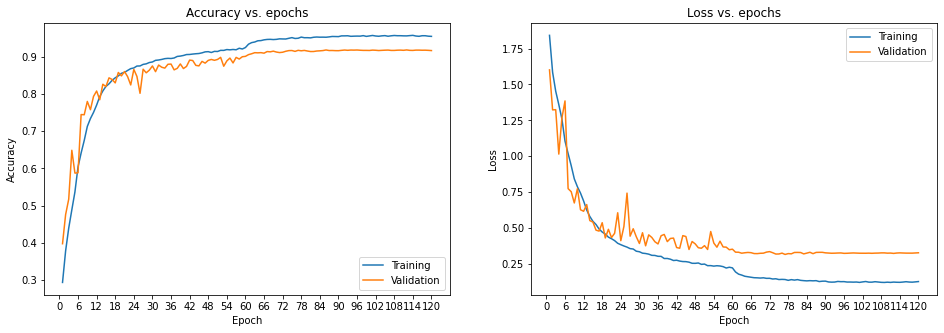

2021-08-10 19:04:17,902: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
----------------------------------------evaluate----------------------------------------


2021-08-10 19:04:36,658: INFO: test loss:0.3240
2021-08-10 19:04:36,659: INFO: test accuracy:0.9189
2021-08-10 19:04:36,661: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 19:04:36,662: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 19:04:36,663: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 19:04:36,664: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 19:04:36,665: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custo

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 19:04:37,945: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


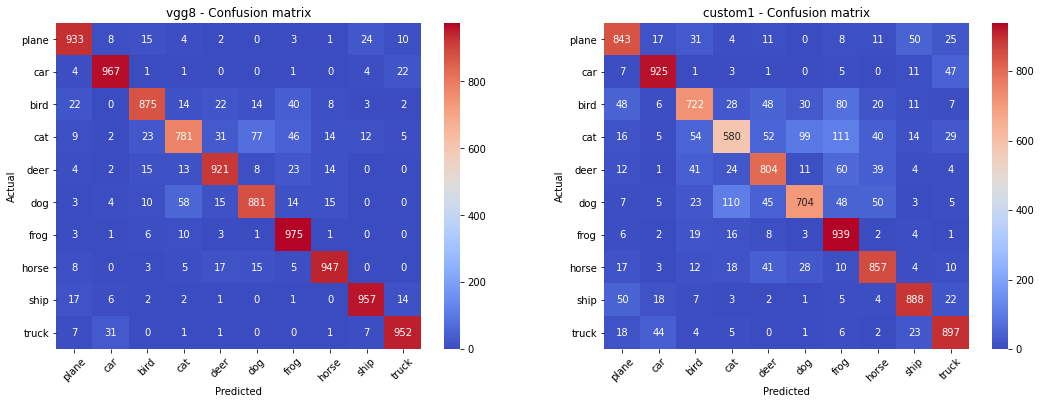

2021-08-10 19:04:42,295: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1


----------------------------------------sample analysis----------------------------------------


2021-08-10 19:04:43,204: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 19:04:43,206: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 19:04:43,966: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 19:04:43,968: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 19:04:48,802: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 19:04:48,803: INFO: loading model from /tf/eipi10/xuxiangwen.gith

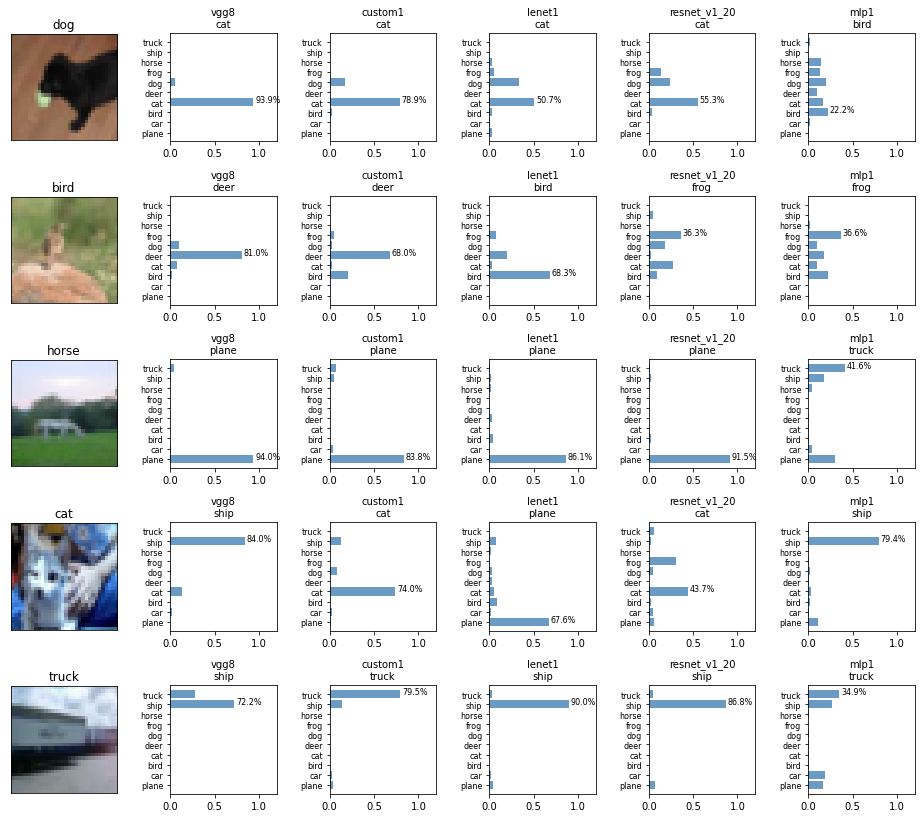

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1672906,4318.8,2021-08-10 19:04,0.0411,0.3240,0.9856,0.9189,0.9999,0.9956
2,custom1,73738,3936.0,2021-08-10 17:51,0.4275,0.5284,0.8501,0.8159,0.9886,0.9827
3,lenet1,83170,3628.4,2021-08-10 16:45,0.6090,0.7320,0.7833,0.7490,0.9776,0.9674
4,resnet_v1_20,273066,56.3,NaN,1.6290,1.6741,0.5311,0.5230,0.9148,0.9110
5,mlp1,394634,3740.2,2021-08-10 15:44,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2021-08-10 19:04:56,074: INFO: learning_rate=0.001
2021-08-10 19:04:56,074: INFO: model_params.resnet_v1_20.clip_value=None
2021-08-10 19:04:56,081: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 19:04:56,101: INFO: model_params.resnet_v1_20.epochs=120
2021-08-10 19:04:56,101: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20, monitor=val_accuracy)
2021-08-10 19:04:56,102: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-08-10 19:04:56,102: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-08-10 19:04:56,103: INFO: use LearningRateScheduler()
2021-08-10 19:04:56,104: INFO: steps_per_epoch=1562
2021-08-10 19:04:56,104: INFO: start training
2021-08-10 19:04:56,105: INFO: use_class_weight=False


Model: "resnet_v1_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization_5[0][0]      
_______________________________________________________________________________________

1562/1562 [==============================] - 40s 24ms/step - loss: 1.5604 - accuracy: 0.4939 - val_loss: 1.5931 - val_accuracy: 0.5283


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:05:47,437: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 2/120
1562/1562 [==============================] - 37s 24ms/step - loss: 1.1465 - accuracy: 0.6519 - val_loss: 1.1752 - val_accuracy: 0.6451


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:06:35,693: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 3/120
1562/1562 [==============================] - 37s 23ms/step - loss: 0.9862 - accuracy: 0.7118 - val_loss: 1.2111 - val_accuracy: 0.6604


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:07:23,504: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 4/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.9008 - accuracy: 0.7475 - val_loss: 1.1885 - val_accuracy: 0.6755


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:08:11,971: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 5/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.8411 - accuracy: 0.7688 - val_loss: 0.9621 - val_accuracy: 0.7363


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:09:00,317: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 6/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.7930 - accuracy: 0.7850 - val_loss: 0.9048 - val_accuracy: 0.7635


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:09:48,576: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 7/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.7626 - accuracy: 0.7981 - val_loss: 0.8298 - val_accuracy: 0.7769


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:10:37,086: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 8/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.7315 - accuracy: 0.8107 - val_loss: 0.9029 - val_accuracy: 0.7645
Epoch 9/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.7126 - accuracy: 0.8160 - val_loss: 1.0095 - val_accuracy: 0.7370
Epoch 10/120
1562/1562 [==============================] - 36s 23ms/step - loss: 0.6964 - accuracy: 0.8247 - val_loss: 0.8512 - val_accuracy: 0.7812


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:12:37,701: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 11/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.6736 - accuracy: 0.8329 - val_loss: 1.2249 - val_accuracy: 0.6856
Epoch 12/120
1562/1562 [==============================] - 33s 21ms/step - loss: 0.6631 - accuracy: 0.8375 - val_loss: 0.9567 - val_accuracy: 0.7519
Epoch 13/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6508 - accuracy: 0.8434 - val_loss: 1.0782 - val_accuracy: 0.7409
Epoch 14/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6417 - accuracy: 0.8450 - val_loss: 0.8405 - val_accuracy: 0.7806
Epoch 15/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.6316 - accuracy: 0.8490 - val_loss: 0.7307 - val_accuracy: 0.8202


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:15:25,982: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 16/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.6235 - accuracy: 0.8529 - val_loss: 0.7379 - val_accuracy: 0.8174
Epoch 17/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.6149 - accuracy: 0.8559 - val_loss: 0.8975 - val_accuracy: 0.7727
Epoch 18/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.6081 - accuracy: 0.8590 - val_loss: 0.8614 - val_accuracy: 0.7912
Epoch 19/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5986 - accuracy: 0.8622 - val_loss: 0.8580 - val_accuracy: 0.7910
Epoch 20/120
1562/1562 [==============================] - 30s 20ms/step - loss: 0.5990 - accuracy: 0.8637 - val_loss: 0.7627 - val_accuracy: 0.8152
Epoch 21/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5916 - accuracy: 0.8655 - val_loss: 0.8299 - val_accuracy: 0.7989
Epoch 22/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5874 - accuracy: 0.8670 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:19:09,686: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 23/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5767 - accuracy: 0.8707 - val_loss: 0.8166 - val_accuracy: 0.8092
Epoch 24/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5760 - accuracy: 0.8702 - val_loss: 0.6730 - val_accuracy: 0.8401


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:20:22,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 25/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5699 - accuracy: 0.8738 - val_loss: 0.8210 - val_accuracy: 0.7993
Epoch 26/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5720 - accuracy: 0.8721 - val_loss: 0.7380 - val_accuracy: 0.8240
Epoch 27/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5644 - accuracy: 0.8758 - val_loss: 0.7418 - val_accuracy: 0.8261
Epoch 28/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5627 - accuracy: 0.8764 - val_loss: 0.8418 - val_accuracy: 0.7985
Epoch 29/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5588 - accuracy: 0.8781 - val_loss: 0.6881 - val_accuracy: 0.8403


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:23:05,233: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 30/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5533 - accuracy: 0.8804 - val_loss: 0.7129 - val_accuracy: 0.8287
Epoch 31/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5498 - accuracy: 0.8813 - val_loss: 0.6793 - val_accuracy: 0.8442


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:24:16,939: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 32/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5514 - accuracy: 0.8805 - val_loss: 0.8775 - val_accuracy: 0.7952
Epoch 33/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5491 - accuracy: 0.8832 - val_loss: 0.7863 - val_accuracy: 0.8230
Epoch 34/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5435 - accuracy: 0.8815 - val_loss: 0.7011 - val_accuracy: 0.8348
Epoch 35/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5427 - accuracy: 0.8855 - val_loss: 0.6915 - val_accuracy: 0.8394
Epoch 36/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5399 - accuracy: 0.8842 - val_loss: 0.6814 - val_accuracy: 0.8394
Epoch 37/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.5355 - accuracy: 0.8862 - val_loss: 0.6832 - val_accuracy: 0.8389
Epoch 38/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.5371 - accuracy: 0.8862 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:29:02,791: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 41/120
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.4095 - accuracy: 0.9259 - val_loss: 0.5800 - val_accuracy: 0.8783
Epoch 42/120
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3970 - accuracy: 0.9271 - val_loss: 0.5401 - val_accuracy: 0.8853


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:30:14,404: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 43/120
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3788 - accuracy: 0.9322 - val_loss: 0.5367 - val_accuracy: 0.8865


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:30:55,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 44/120
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3713 - accuracy: 0.9329 - val_loss: 0.5377 - val_accuracy: 0.8841
Epoch 45/120
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3600 - accuracy: 0.9348 - val_loss: 0.5303 - val_accuracy: 0.8874


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:32:07,391: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 46/120
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3536 - accuracy: 0.9354 - val_loss: 0.5166 - val_accuracy: 0.8903


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:32:48,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 47/120
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3483 - accuracy: 0.9377 - val_loss: 0.5886 - val_accuracy: 0.8723
Epoch 48/120
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3403 - accuracy: 0.9373 - val_loss: 0.5207 - val_accuracy: 0.8896
Epoch 49/120
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3338 - accuracy: 0.9394 - val_loss: 0.5496 - val_accuracy: 0.8780
Epoch 50/120
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.3296 - accuracy: 0.9401 - val_loss: 0.5599 - val_accuracy: 0.8816
Epoch 51/120
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.3

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:40:37,752: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 62/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2445 - accuracy: 0.9638 - val_loss: 0.4656 - val_accuracy: 0.8997
Epoch 63/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2404 - accuracy: 0.9648 - val_loss: 0.4614 - val_accuracy: 0.9021


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:41:49,010: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 64/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2338 - accuracy: 0.9660 - val_loss: 0.4574 - val_accuracy: 0.9039


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:42:30,318: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 65/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2296 - accuracy: 0.9671 - val_loss: 0.4622 - val_accuracy: 0.9073


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:43:10,793: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 66/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2260 - accuracy: 0.9682 - val_loss: 0.4780 - val_accuracy: 0.8994
Epoch 67/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2225 - accuracy: 0.9692 - val_loss: 0.4707 - val_accuracy: 0.9025
Epoch 68/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2220 - accuracy: 0.9685 - val_loss: 0.4828 - val_accuracy: 0.9011
Epoch 69/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2160 - accuracy: 0.9699 - val_loss: 0.4734 - val_accuracy: 0.9038
Epoch 70/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.2133 - accuracy: 0.9717 - val_loss: 0.4879 - val_accuracy: 0.9009
Epoch 71/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2118 - accuracy: 0.9711 - val_loss: 0.4783 - val_accuracy: 0.9052
Epoch 72/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.2091 - accuracy: 0.9717 - val_

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:51:00,829: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 81/120
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1806 - accuracy: 0.9797 - val_loss: 0.4632 - val_accuracy: 0.9072
Epoch 82/120
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1793 - accuracy: 0.9796 - val_loss: 0.4572 - val_accuracy: 0.9090
Epoch 83/120
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1769 - accuracy: 0.9810 - val_loss: 0.4619 - val_accuracy: 0.9076
Epoch 84/120
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1738 - accuracy: 0.9818 - val_loss: 0.4648 - val_accuracy: 0.9077
Epoch 85/120
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 19:57:50,027: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 94/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1637 - accuracy: 0.9842 - val_loss: 0.4607 - val_accuracy: 0.9091
Epoch 95/120
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1636 - accuracy: 0.9846 - val_loss: 0.4639 - val_accuracy: 0.9077

Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
Epoch 96/120
Epoch 00096: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1613 - accuracy: 0.9853 - val_loss: 0.4601 - val_accuracy: 0.9091
Epoch 97/120
Epoch 00097: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1623 - accuracy: 0.9847 - val_loss: 0.4579 - val_accuracy: 0.9103
Epoch 98/120
Epoch 00098: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1636 - accuracy: 0.9837 - val_loss: 0.4580 - val_accura

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 20:02:35,274: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 103/120
Epoch 00103: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 30s 20ms/step - loss: 0.1601 - accuracy: 0.9854 - val_loss: 0.4586 - val_accuracy: 0.9104
Epoch 104/120
Epoch 00104: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1592 - accuracy: 0.9855 - val_loss: 0.4589 - val_accuracy: 0.9099
Epoch 105/120
Epoch 00105: Still keep learning rate 3.2e-06 instead of 1e-05
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1603 - accuracy: 0.9853 - val_loss: 0.4575 - val_accuracy: 0.9105
Epoch 106/120
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 3.2e-06.
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1593 - accuracy: 0.9860 - val_loss: 0.4594 - val_accuracy: 0.9103
Epoch 107/120
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1606 - accuracy: 0.9854 - val_loss: 0.4598 - val_ac

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


2021-08-10 20:08:22,164: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20/assets


Epoch 114/120
Epoch 00114: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1591 - accuracy: 0.9858 - val_loss: 0.4587 - val_accuracy: 0.9107
Epoch 115/120
Epoch 00115: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1583 - accuracy: 0.9860 - val_loss: 0.4601 - val_accuracy: 0.9108
Epoch 116/120
Epoch 00116: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 30s 19ms/step - loss: 0.1584 - accuracy: 0.9859 - val_loss: 0.4602 - val_accuracy: 0.9111
Epoch 117/120
Epoch 00117: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1601 - accuracy: 0.9853 - val_loss: 0.4596 - val_accuracy: 0.9105
Epoch 118/120
Epoch 00118: Still keep learning rate 5e-07 instead of 1e-06
1562/1562 [==============================] - 31s 20ms/step - loss: 0.1570 - accuracy:

2021-08-10 20:11:56,607: INFO: finish training [elapsed time: 4020.50 seconds]


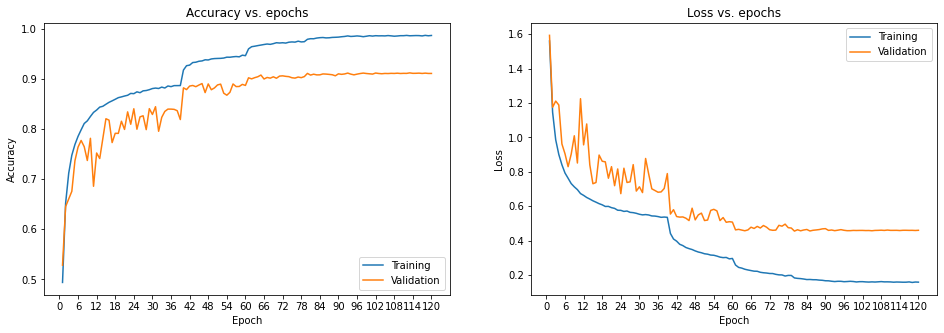

2021-08-10 20:11:57,229: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
----------------------------------------evaluate----------------------------------------


2021-08-10 20:12:29,319: INFO: test loss:0.4599
2021-08-10 20:12:29,320: INFO: test accuracy:0.9116
2021-08-10 20:12:29,325: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 20:12:29,326: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json
2021-08-10 20:12:29,327: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:29,328: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:29,329: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-08-10 20:12:30,770: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator


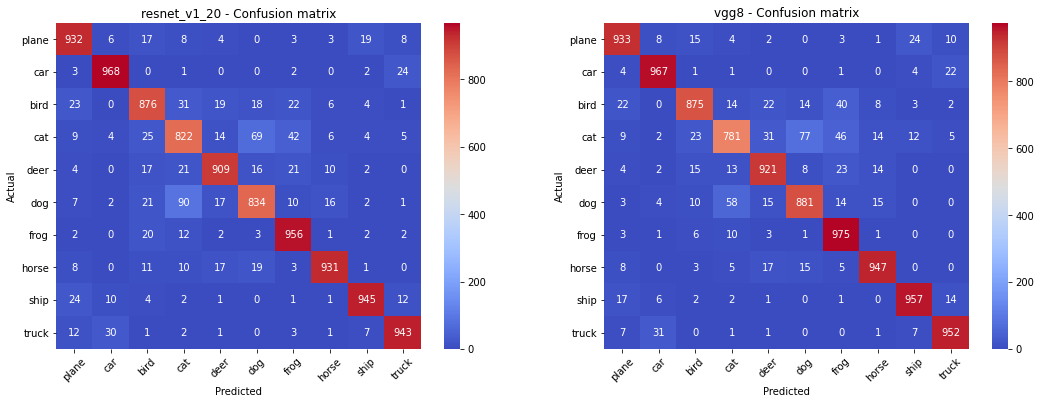

2021-08-10 20:12:36,428: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8


----------------------------------------sample analysis----------------------------------------


2021-08-10 20:12:37,875: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:37,877: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/custom1
2021-08-10 20:12:38,729: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:38,732: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/lenet1
2021-08-10 20:12:39,462: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:39,465: INFO: loading model from /tf/eipi10/xuxiangwen.github.io

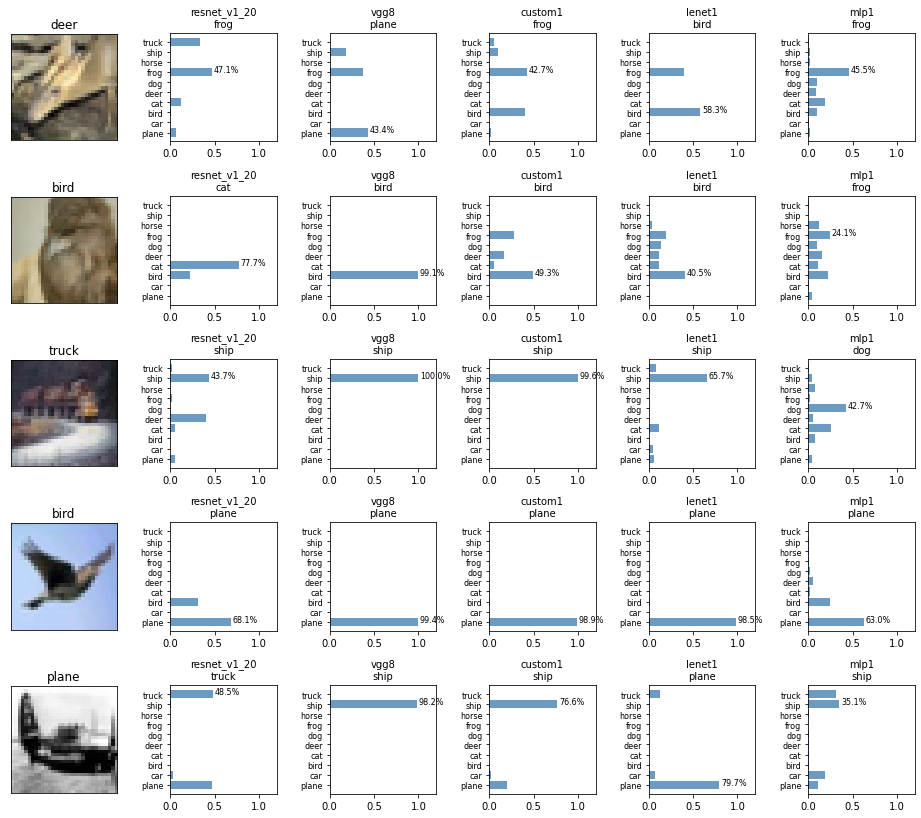

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,1672906,4318.8,2021-08-10 19:04,0.0411,0.3240,0.9856,0.9189,0.9999,0.9956
2,resnet_v1_20,273066,4020.0,2021-08-10 20:12,0.1530,0.4599,0.9877,0.9116,0.9999,0.9950
3,custom1,73738,3936.0,2021-08-10 17:51,0.4275,0.5284,0.8501,0.8159,0.9886,0.9827
4,lenet1,83170,3628.4,2021-08-10 16:45,0.6090,0.7320,0.7833,0.7490,0.9776,0.9674
5,mlp1,394634,3740.2,2021-08-10 15:44,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518


In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

## 评估

### 最佳模型

In [30]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-08-11 00:54:06,377: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2021-08-11 00:54:06,379: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-08-11 00:54:06,380: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/results.json


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,cifar10_0721_p100_aug.ipynb,1672906,4318.8,2021-08-10 19:04,0.0411,0.3240,0.9856,0.9189,0.9999,0.9956
2,resnet_v1_20,cifar10_0721_p100_aug.ipynb,273066,4020.0,2021-08-10 20:12,0.1530,0.4599,0.9877,0.9116,0.9999,0.9950
3,vgg8,cifar10_0721_p100.ipynb,1672906,5103.7,2021-08-10 11:14,0.0022,0.6000,0.9995,0.8926,1.0000,0.9923
4,resnet_v1_20,cifar10_0721_p100.ipynb,273066,4856.7,2021-08-10 12:36,0.2574,1.1289,0.9970,0.8217,1.0000,0.9804
5,custom1,cifar10_0721_p100_aug.ipynb,73738,3936.0,2021-08-10 17:51,0.4275,0.5284,0.8501,0.8159,0.9886,0.9827
6,custom1,cifar10_0721_p100.ipynb,73738,2123.6,NaN,0.3079,0.6009,0.8943,0.8008,0.9941,0.9785
7,lenet1,cifar10_0721_p100_aug.ipynb,83170,3628.4,2021-08-10 16:45,0.6090,0.7320,0.7833,0.7490,0.9776,0.9674
8,lenet1,cifar10_0721_p100.ipynb,83170,1099.0,NaN,0.4480,0.7639,0.8460,0.7404,0.9878,0.9645
9,mlp1,cifar10_0721_p100_aug.ipynb,394634,3740.2,2021-08-10 15:44,1.5691,1.5668,0.4396,0.4402,0.8517,0.8518
10,mlp1,cifar10_0721_p100.ipynb,394634,505.6,NaN,1.7550,1.7995,0.3752,0.3531,0.8083,0.7939


2021-08-10 20:12:46,460: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/vgg8
2021-08-10 20:12:47,905: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:47,908: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/resnet_v1_20
2021-08-10 20:12:52,507: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100_aug/val_test.generator
2021-08-10 20:12:52,509: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2021-08-10 20:12:53,913: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/5

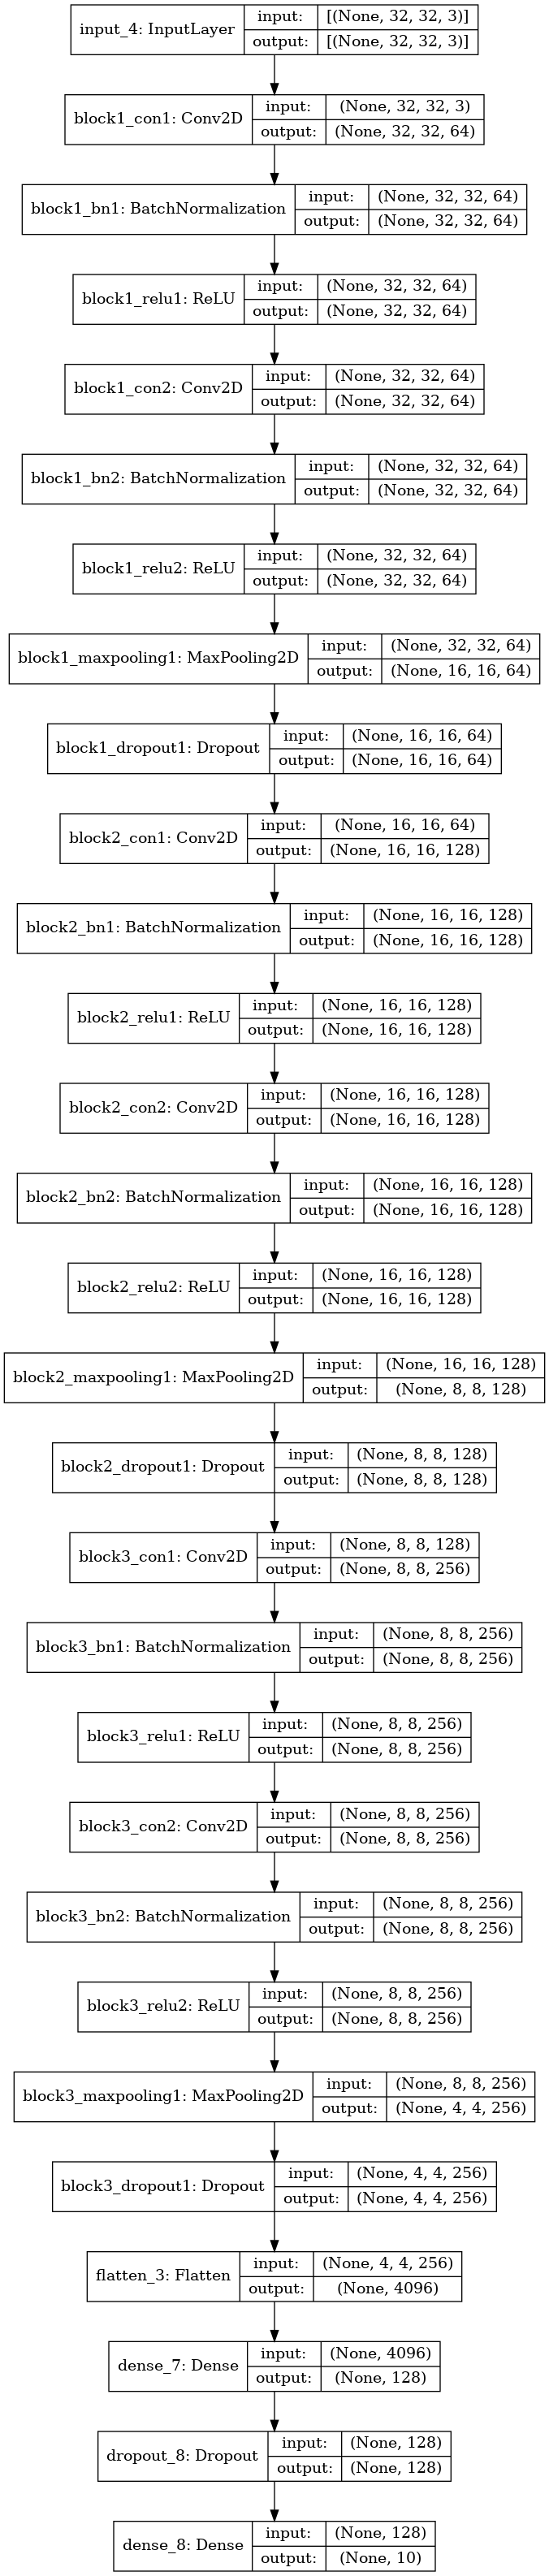

In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

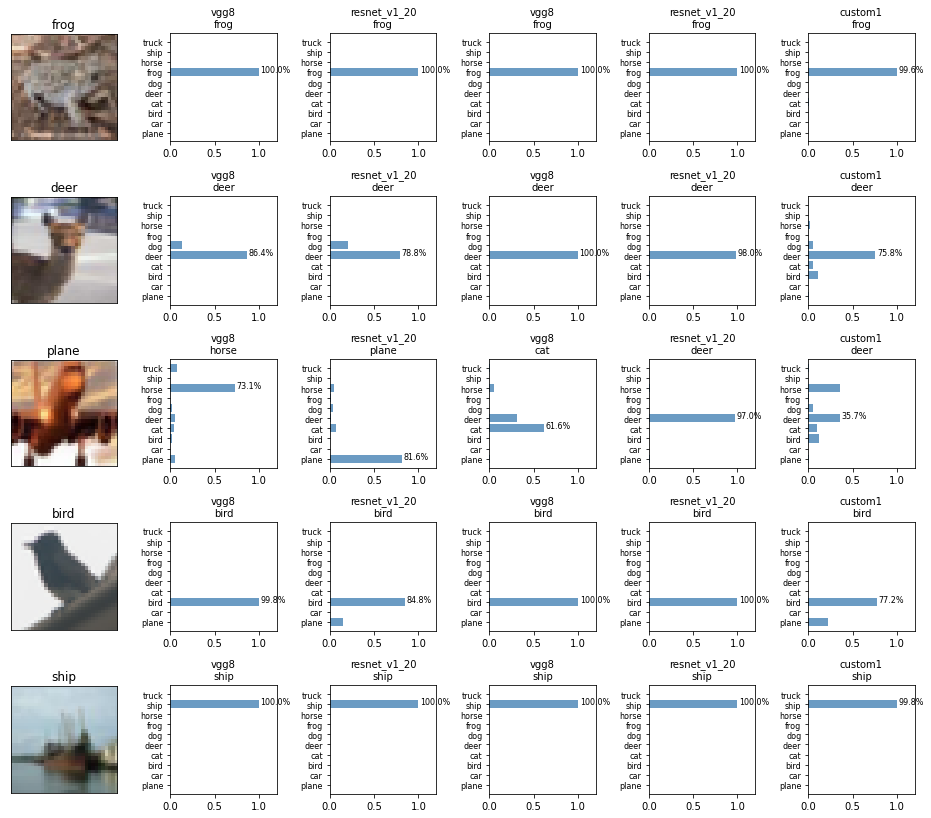

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

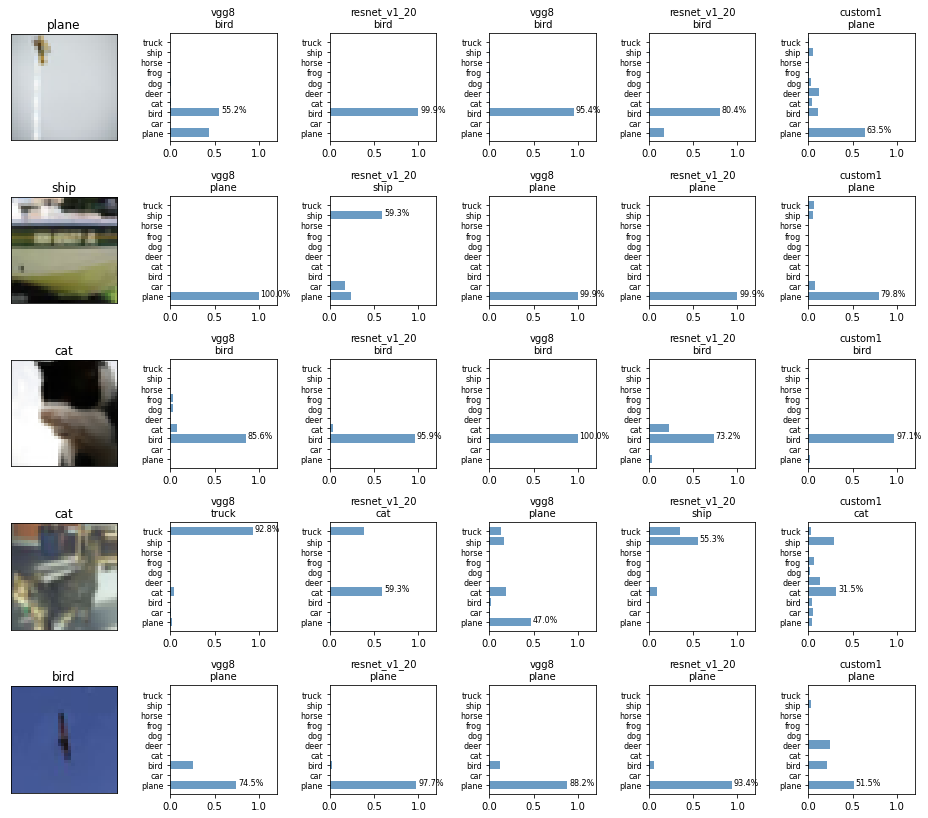

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.3240383565425873, 'accuracy': 0.9189000129699707, 'mae': 24.28032875061035}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
plane,0.923762,0.933,0.928358
car,0.947111,0.967,0.956952
bird,0.921053,0.875,0.897436
cat,0.878515,0.781,0.826893
deer,0.909181,0.921,0.915052
dog,0.884538,0.881,0.882766
frog,0.879964,0.975,0.925047
horse,0.946054,0.947,0.946527
ship,0.950348,0.957,0.953662
truck,0.947264,0.952,0.949626


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9238    0.9330    0.9284      1000
         car     0.9471    0.9670    0.9570      1000
        bird     0.9211    0.8750    0.8974      1000
         cat     0.8785    0.7810    0.8269      1000
        deer     0.9092    0.9210    0.9151      1000
         dog     0.8845    0.8810    0.8828      1000
        frog     0.8800    0.9750    0.9250      1000
       horse     0.9461    0.9470    0.9465      1000
        ship     0.9503    0.9570    0.9537      1000
       truck     0.9473    0.9520    0.9496      1000

    accuracy                         0.9189     10000
   macro avg     0.9188    0.9189    0.9182     10000
weighted avg     0.9188    0.9189    0.9182     10000



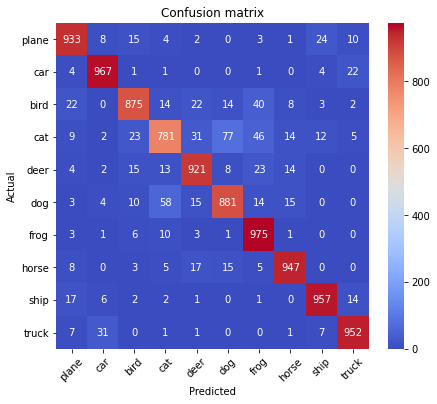

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.keras.preprocessing.image.NumpyArrayIterator